In [1]:
from utils.load_utils import get_exp_meta

# EXPERIMENT META 
exp_code = "b1378"
exp_meta = get_exp_meta(exp_code)
run_code = "05"
desired_sampling_freq = 100

In [2]:
import os

# JUPYTER
# %matplotlib widget
%reload_ext autoreload
%autoreload 2

# FILENAMES
working_dir = os.getcwd()
data_dir = working_dir + "/data"
results_dir = working_dir + "/results/" + run_code
datapath = data_dir + "/" + exp_code + ".txt"
picklepath = data_dir + '/' + exp_code + "_" + str(desired_sampling_freq) + "hz.pickle"

# MAKE RESULTS DIR IF NOT EXISTS
if os.path.exists(results_dir):
    if os.listdir(results_dir):
        print("WARNING: results dir already contains data")
else:
    os.makedirs(results_dir)

## Import data

Importing BRAVA data...
...reading pickle...
... data imported

       V-LVDT    H-LVDT  SHEAR STRESS  NORMAL STRESS  ON BOARD LVDT  \
1 -20.458876  3.900012     36.392466      37.496096    8085.390963   
2 -19.756089  3.828950     36.149439      37.502314    7401.586860   
3 -20.172372  3.870818     36.278847      37.497589    7805.820603   
4 -19.875916  3.840934     36.194602      37.503356    7518.537433   
5 -20.106215  3.864276     36.257370      37.497426    7741.648624   

   V Load aux     TIME  NORMALISED SHEAR  
1    1.817732  2466.01          0.719940  
2    1.805686  2466.02          0.636561  
3    1.812695  2466.03          0.680959  
4    1.808001  2466.04          0.652056  
5    1.812111  2466.05          0.673591  


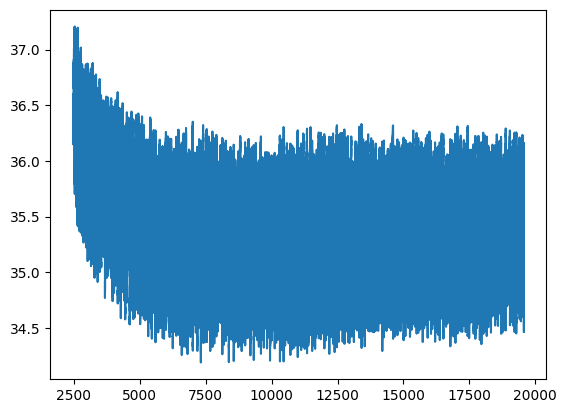

In [3]:
from utils.load_utils import import_brava_data
import matplotlib.pyplot as plt

# IMPORT
args = dict((k, exp_meta[k]) for k in ["t_start", "t_end", "ROIs"] if k in exp_meta)
data = import_brava_data(datapath, picklepath, downsample_factor=(exp_meta["sampling_freq"] / desired_sampling_freq), **args)

# HAVE A LOOK
print("\n", data.head())
# plt.close("all")
plt.plot(data["TIME"], data["SHEAR STRESS"])
# plt.show()

## Generate windows

In [4]:
# sliding windows
win_length = 250000
win_offset = 125000

num_wins = (len(data) - win_length) // win_offset
windows = []
for i in range(num_wins):
    windows.append((i*win_offset, i*win_offset + win_length))
print("Number of windows:", num_wins)

Number of windows: 11


In [5]:
# turn ROIs into windows
# windows = []
# for roi in exp_meta["ROIs"]:
#     masked = data[ data["TIME"].between(roi[0], roi[1]) ]
#     windows.append((masked.index[0], masked.index[-1]))

## Set dynamics parameters

In [6]:
import numpy as np
dynsys_params = {

    # CALCULATE BEST m, tau BY CAO (1997)
    "tau_to_try": np.array([5,15,30,50,80,120,170,250]),
    "m_to_try": np.arange(1,13,1),
    "E1_threshold": 0.9,
    "E2_threshold": 0.9,
    "eps_over_L0": 0.05,
    "n_neighbors": 13,

    # LYAPUNOV CALCULATIONS
    "sampling": ['rand',None] # to calculate LE spectrum

}

## Package everything up

In [7]:
import pickle
import json
from utils.load_utils import JsonEncoder

# COLLECT OPTS
opts = {
    "exp_code": exp_code,
    "exp_meta": exp_meta,
    "sampling_freq": desired_sampling_freq,
    "run_code": run_code,
    "working_dir": working_dir,
    "data_dir": data_dir,
    "results_dir": results_dir,
    "datapath": datapath,
    "picklepath": picklepath,
    "windows": windows,
    "dynsys_params": dynsys_params
}

# WRITE TO PICKLE
opts_picklepath = results_dir + "/opts.pickle"
with open(opts_picklepath, 'wb') as f:
    pickle.dump(opts, f)

# WRITE TO JSON
opts_jsonpath = results_dir + "/opts.json"
with open(opts_jsonpath, 'w') as f_:
    f_.write( json.dumps(opts, indent=4, cls=JsonEncoder) )
